<a href="https://colab.research.google.com/github/mkane968/Text-Mining-with-Student-Papers/blob/main/Text_Mining_Student_Essays_A_Computational_Exploration_DRAFT_12_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Mining Student Essays: A Computational Exploration

This pipeline will ingest, clean and analyze meaningful language patterns in a corpora of student papers. The following input is required: 

*   Corpus of student papers (.txt files)
*   Grades and other relevant metadata associated with the papers (.csv files)


## 1. Install Packages

In [26]:
#Mount Google Drive
from google.colab import drive
from google.colab import files

#Install glob
import glob 

#Install pandas
import pandas as pd

#Install numpy
import numpy as np

#Imports the Natural Language Toolkit, which is necessary to install NLTK packages and libraries
#!pip install nltk
import nltk

#Installs libraries and packages to tokenize text
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
from  nltk.text import ConcordanceIndex

#Installs libraries and packages to clean text
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

#Import matplotlib for visualizations
import matplotlib.pyplot as plt


#Imports spaCy itself, necessary to use features 
#!pip install spaCy
import spacy
#Load the natural language processing pipeline
nlp = spacy.load("en_core_web_sm")
#Load spaCy visualizer
from spacy import displacy

from scipy import stats

import re  # For preprocessing
from time import time  # To time our operations
from collections import defaultdict  # For word frequency
import logging  # Setting up the loggings to monitor gensim

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Import Student Essays and Metadata

###Import Student Essays and Add to DataFrame

In [4]:
#Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#Add files to upload from local machine
uploaded = files.upload()

Saving achesonalessandro_193606_13858036_Final Portfolio Eng 802 - Acheson .txt to achesonalessandro_193606_13858036_Final Portfolio Eng 802 - Acheson .txt
Saving ahenkoraravenmanu_LATE_232002_18873129_English 0802 Portfolio - Raven Ahenkora.txt to ahenkoraravenmanu_LATE_232002_18873129_English 0802 Portfolio - Raven Ahenkora.txt
Saving bedellolivia_195145_16640649_Analytical Reading and Writing Final Portfolio.txt to bedellolivia_195145_16640649_Analytical Reading and Writing Final Portfolio.txt
Saving benjamincamillia_193400_11506010_Camillia Benjamin Final Portfolio.txt to benjamincamillia_193400_11506010_Camillia Benjamin Final Portfolio.txt
Saving bernsteingage_LATE_227638_18903293_Final Portfolio- English 0802.txt to bernsteingage_LATE_227638_18903293_Final Portfolio- English 0802.txt
Saving bortolottiryan_LATE_232933_18872422_Portfolio.txt to bortolottiryan_LATE_232933_18872422_Portfolio.txt
Saving braunsteinaydan_232993_19273434_Final Portfolio.txt to braunsteinaydan_232993_192

In [6]:
#Put essays into dataframe
essays = pd.DataFrame.from_dict(uploaded, orient='index')

#Reset index and add column names to make wrangling easier
essays = essays.reset_index()
essays.columns = ["ID", "Text"]

#Remove encoding characters from Text column (b'\xef\xbb\xbf)
essays['Text'] = essays['Text'].apply(lambda x: x.decode('utf-8'))

#Remove newline characters and put in new column 
essays['Text_Newlines'] = essays['Text']
essays['Text'] = essays['Text'].str.replace(r'\s+|\\r', ' ', regex=True) 
essays['Text'] = essays['Text'].str.replace(r'\s+|\\n', ' ', regex=True) 
essays.head()

,ID,Text,Text_Newlines
0,achesonalessandro_193606_13858036_Final Portfo...,"I have learned a lot through English 802, mor...","\tI have learned a lot through English 802, mo..."
1,ahenkoraravenmanu_LATE_232002_18873129_English...,Raven Ahenkora Professor Megan Kane English 08...,Raven Ahenkora\nProfessor Megan Kane\nEnglish ...
2,bedellolivia_195145_16640649_Analytical Readin...,Olivia Bedell Professor Megan Kane ENG 802 14 ...,Olivia Bedell\nProfessor Megan Kane\nENG 802\n...
3,benjamincamillia_193400_11506010_Camillia Benj...,Camillia Benjamin Prof. Kane English 802 06 De...,Camillia Benjamin\nProf. Kane\nEnglish 802\n06...
4,bernsteingage_LATE_227638_18903293_Final Portf...,Bernstein 1 Gage Bernstein English 0802 Profes...,Bernstein 1\nGage Bernstein\nEnglish 0802\nPro...


### Add column without identifying information from each paper ID (instructor/student names) 

In [7]:
#Remove identifying information from ID
#Remove any occurences of "LATE_" from dataset (otherwise will skew ID cleaning)
essays['ID'] = essays['ID'].str.replace(r'LATE_', '', regex=True) 

#Split book on first underscore (_) in ID, keep only text in between first and second underscore (ID number)
start = essays["ID"].str.split("_", expand = True)
essays['ID'] = start[1]
essays['ID'] = essays['ID'].astype(int)
essays

,ID,Text,Text_Newlines
0,193606,"I have learned a lot through English 802, mor...","\tI have learned a lot through English 802, mo..."
1,232002,Raven Ahenkora Professor Megan Kane English 08...,Raven Ahenkora\nProfessor Megan Kane\nEnglish ...
2,195145,Olivia Bedell Professor Megan Kane ENG 802 14 ...,Olivia Bedell\nProfessor Megan Kane\nENG 802\n...
3,193400,Camillia Benjamin Prof. Kane English 802 06 De...,Camillia Benjamin\nProf. Kane\nEnglish 802\n06...
4,227638,Bernstein 1 Gage Bernstein English 0802 Profes...,Bernstein 1\nGage Bernstein\nEnglish 0802\nPro...
...,...,...,...
98,189740,Isabella Volpe Professor Kane ENG 802 21 April...,Isabella Volpe\nProfessor Kane\nENG 802\n21 Ap...
99,186629,Amaya Whipple Professor Megan Kane ENG 802 9 F...,Amaya Whipple\nProfessor Megan Kane\nENG 802\n...
100,185528,Ashrita Yellani Professor Kane English 0802 De...,Ashrita Yellani\nProfessor Kane\nEnglish 0802\...
101,189403,Yuknek 1 Kathryn Yuknek Professor Kane ENG 802...,Yuknek 1\n\n\nKathryn Yuknek\n\n\nProfessor Ka...


In [ ]:
len(essays)

### Import grades and additional metadata to second dataframe


In [8]:
#Upload csvs with essay metadata
uploaded_grades = files.upload()

Saving 2022-09-13T0943_Grades-LA-ENG-0802-711-10742-202220.csv to 2022-09-13T0943_Grades-LA-ENG-0802-711-10742-202220.csv
Saving 2022-09-13T0945_Grades-LA-ENG-0802-062-37264-202203.csv to 2022-09-13T0945_Grades-LA-ENG-0802-062-37264-202203.csv
Saving 2022-11-28T1326_Grades-LA-ENG-0802-011-4684-202103.csv to 2022-11-28T1326_Grades-LA-ENG-0802-011-4684-202103.csv
Saving 2022-11-28T1331_Grades-LA-ENG-0802-012-3352-202136.csv to 2022-11-28T1331_Grades-LA-ENG-0802-012-3352-202136.csv
Saving 2022-11-28T1332_Grades-LA-ENG-0802-010-3350-202036.csv to 2022-11-28T1332_Grades-LA-ENG-0802-010-3350-202036.csv


In [9]:
#Link to path where csv files are stored in drive
local_path = r'/content'

#Create variable to store all csvs in path
filenames = glob.glob(local_path + "/*.csv")

#Create df list for all csvs
dfs = [pd.read_csv(filename) for filename in filenames]

len(filenames)

5

In [ ]:
print(filenames)

In [10]:
# Concatenate all data into one DataFrame
metadata = pd.concat(dfs, ignore_index=True)

#Change data to string (for further cleaning)
metadata.astype(str)

metadata.head()

,Student,ID,SIS Login ID,Section,Final Portfolio (1059452),Assignments Current Score,Assignments Unposted Current Score,Assignments Final Score,Assignments Unposted Final Score,Portfolio Current Score,...,Final Portfolio (1313717),Final Portfolio (1676963),Attendance and Weekly Assignments Current Score,Attendance and Weekly Assignments Unposted Current Score,Attendance and Weekly Assignments Final Score,Attendance and Weekly Assignments Unposted Final Score,Portfolio Preparation Current Score,Portfolio Preparation Unposted Current Score,Portfolio Preparation Final Score,Portfolio Preparation Unposted Final Score
0,Points Possible,NaN,NaN,NaN,100.0,(read only),(read only),(read only),(read only),(read only),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Acheson, Alessandro",193606.0,tun36083,Section: 011,94.0,NaN,NaN,NaN,NaN,94.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Collins, Gabriela",189553.0,tul28908,Section: 011,83.0,NaN,NaN,NaN,NaN,83.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"D'Ambrosio, Michele",192315.0,tun05297,Section: 011,88.0,NaN,NaN,NaN,NaN,88.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Dagostino, Reno Joseph",185491.0,tun31343,Section: 011,88.0,NaN,NaN,NaN,NaN,88.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
#Drop header rows(Points Possible) and test student rows (Student, Test)
metadata = metadata[metadata['Student'].str.contains('Points Possible|Student, Test')==False]
metadata.head()

,Student,ID,SIS Login ID,Section,Final Portfolio (1059452),Assignments Current Score,Assignments Unposted Current Score,Assignments Final Score,Assignments Unposted Final Score,Portfolio Current Score,...,Final Portfolio (1313717),Final Portfolio (1676963),Attendance and Weekly Assignments Current Score,Attendance and Weekly Assignments Unposted Current Score,Attendance and Weekly Assignments Final Score,Attendance and Weekly Assignments Unposted Final Score,Portfolio Preparation Current Score,Portfolio Preparation Unposted Current Score,Portfolio Preparation Final Score,Portfolio Preparation Unposted Final Score
1,"Acheson, Alessandro",193606.0,tun36083,Section: 011,94.0,NaN,NaN,NaN,NaN,94.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Collins, Gabriela",189553.0,tul28908,Section: 011,83.0,NaN,NaN,NaN,NaN,83.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"D'Ambrosio, Michele",192315.0,tun05297,Section: 011,88.0,NaN,NaN,NaN,NaN,88.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Dagostino, Reno Joseph",185491.0,tun31343,Section: 011,88.0,NaN,NaN,NaN,NaN,88.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,"Francis, Melanie",177737.0,tuk18465,Section: 011,86.0,NaN,NaN,NaN,NaN,86.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
#Keep only relevant metadata (ID, Section, Final Portfolio Scores)
clean_metadata = metadata[['ID'] + ['Section'] + list(metadata.loc[:, metadata.columns.str.startswith('Final Portfolio (')])]
clean_metadata.head()
#Want other metadata? Check the columns
#Get all column names 
#for col in metadata.columns:
   # print(col)

,ID,Section,Final Portfolio (1059452),Final Portfolio (1689777),Final Portfolio (878160),Final Portfolio (1313717),Final Portfolio (1676963)
1,193606.0,Section: 011,94.0,NaN,NaN,NaN,NaN
2,189553.0,Section: 011,83.0,NaN,NaN,NaN,NaN
3,192315.0,Section: 011,88.0,NaN,NaN,NaN,NaN
4,185491.0,Section: 011,88.0,NaN,NaN,NaN,NaN
5,177737.0,Section: 011,86.0,NaN,NaN,NaN,NaN


In [13]:
#Replace all NaN values with 0 
clean_metadata = clean_metadata.replace(np.nan, 0)
clean_metadata.head()

,ID,Section,Final Portfolio (1059452),Final Portfolio (1689777),Final Portfolio (878160),Final Portfolio (1313717),Final Portfolio (1676963)
1,193606.0,Section: 011,94.0,0.0,0.0,0.0,0.0
2,189553.0,Section: 011,83.0,0.0,0.0,0.0,0.0
3,192315.0,Section: 011,88.0,0.0,0.0,0.0,0.0
4,185491.0,Section: 011,88.0,0.0,0.0,0.0,0.0
5,177737.0,Section: 011,86.0,0.0,0.0,0.0,0.0


In [14]:
#Create new final portfolio column with all values
#Add values of each column together; values except correct grade will be zero
score_counts = clean_metadata.columns[2:]
clean_metadata['Portfolio_Score'] = clean_metadata[score_counts].sum(axis=1)
clean_metadata['Portfolio_Score']

1      94.0
2      83.0
3      88.0
4      88.0
5      86.0
       ... 
119    90.0
120    93.0
121    88.0
122    92.0
123    89.0
Name: Portfolio_Score, Length: 115, dtype: float64

In [15]:
#Drop grade columns for individual classes
clean_metadata = clean_metadata[['ID', 'Section', "Portfolio_Score"]]
clean_metadata.head()

,ID,Section,Portfolio_Score
1,193606.0,Section: 011,94.0
2,189553.0,Section: 011,83.0
3,192315.0,Section: 011,88.0
4,185491.0,Section: 011,88.0
5,177737.0,Section: 011,86.0


In [16]:
#Drop decimal from ID (inconsistent with ID in essay dataframe)
clean_metadata['ID'] = clean_metadata['ID'].astype(int)

#Check cleaned DF one more time
clean_metadata.head()

,ID,Section,Portfolio_Score
1,193606,Section: 011,94.0
2,189553,Section: 011,83.0
3,192315,Section: 011,88.0
4,185491,Section: 011,88.0
5,177737,Section: 011,86.0


### Merge essays and grade metadata into one dataframe

In [17]:
#Merge metadata and cleaned essays into new dataframe
#Will only keep rows where both essay and metadata are present
essays_grades_master = clean_metadata.merge(essays,on='ID')

#Print dataframe
essays_grades_master

,ID,Section,Portfolio_Score,Text,Text_Newlines
0,193606,Section: 011,94.0,"I have learned a lot through English 802, mor...","\tI have learned a lot through English 802, mo..."
1,189553,Section: 011,83.0,Gabriela Collins Megan Kane English 0802 26 Ap...,Gabriela Collins \nMegan Kane\nEnglish 0802\n2...
2,192315,Section: 011,88.0,Michele D’Ambrosio Professor Kane Eng0802 21 A...,Michele D’Ambrosio \nProfessor Kane\nEng0802\n...
3,185491,Section: 011,88.0,Reno Dagostino Analytical Reading and Writing ...,Reno Dagostino\nAnalytical Reading and Writing...
4,177737,Section: 011,86.0,Melanie Francis Professor Kane Analytical Read...,Melanie Francis\nProfessor Kane\nAnalytical Re...
...,...,...,...,...,...
98,217053,Section: 062,90.0,"Marion Schroder Apr 25, 2022 Professor Megan K...","Marion Schroder\nApr 25, 2022\n\nProfessor Meg..."
99,192683,Section: 062,93.0,Siah Thach Professor Megan Kane ENG 802 25 Apr...,Siah Thach\nProfessor Megan Kane\nENG 802\n25 ...
100,233407,Section: 062,88.0,Metshet Tilahun Professor Kane ENG 0802 April ...,Metshet Tilahun\nProfessor Kane\nENG 0802\nApr...
101,226726,Section: 062,92.0,Sydney Tomman Professor Megan Kane ENG 802 25 ...,Sydney Tomman \nProfessor Megan Kane\nENG 802\...


In [18]:
#Sort dataframe by grades
essays_grades_master.sort_values(by=['Portfolio_Score'], inplace = True)
essays_grades_master

,ID,Section,Portfolio_Score,Text,Text_Newlines
5,199773,Section: 011,66.0,Liam A. Hart Megan Kane Analytical Reading and...,Liam A. Hart\nMegan Kane\nAnalytical Reading a...
13,202621,Section: 011,73.0,Paper 1 Michelle McCarthy Professor Megan Kane...,Paper 1 \n\nMichelle McCarthy\nProfessor Megan...
37,157620,Section: 010,76.0,Stacey Brizard Dr Megan Kane Eng 802 12/02/202...,Stacey Brizard \n\nDr Megan Kane\n\nEng 802\n\...
42,158545,Section: 010,76.0,Page 1 Final reflection Kowalski Megan Kane Te...,Page 1\n\n\nFinal reflection\n\n\nKowalski\n\n...
38,186448,Section: 010,79.0,Thomas Butts Analytical Reading and Writing Pr...,Thomas Butts\nAnalytical Reading and Writing\n...
...,...,...,...,...,...
92,225111,Section: 062,96.0,Cam McWilliams Professor Megan Kane ENG 0802 2...,Cam McWilliams \nProfessor Megan Kane\nENG 080...
93,214736,Section: 062,96.0,Allanah Nelligan Megan Kane Eng 0802 25 April ...,Allanah Nelligan\nMegan Kane\nEng 0802\n25 Apr...
94,227737,Section: 062,96.0,Morgan Owen Professor Megan Kane English 0802 ...,Morgan Owen Professor Megan Kane English 0802\...
89,230811,Section: 062,97.0,Sakshi Gawde Professor Kane ENG 0802 30 Januar...,Sakshi Gawde Professor Kane ENG 0802\n30 Janua...


In [ ]:
#Save new df to csv and download
essays_grades_master.to_csv('essays_grades_master.csv') 
files.download('essays_grades_master.csv')

In [19]:
#Save and download de-identified essays for future analysis
#Add each text to a new list called paragraph_context
deidentified_texts = []
for row in essays_grades_master['Text'].items():
    row_string = (str(row[1]))
    deidentified_texts.append(row_string)

#Add filenames to list
filenames = []
for row in essays_grades_master['ID'].items():
    row_string = (str(row[1]))
    filenames.append(row_string)

filenames[1]

#Make new directory to store text files
!mkdir deidentified_texts

#Write texts to files
n = 0
for item in deidentified_texts:
  f = open("deidentified_texts/" + filenames[n],'w')
  n= n+1
  f.write(item)
  f.close()

#Zip text files in folder
!zip -r deidentified_texts.zip deidentified_texts

#Download file to zip folder to run through DocuScope
files.download('deidentified_texts.zip')

  adding: deidentified_texts/ (stored 0%)
  adding: deidentified_texts/223398 (deflated 62%)
  adding: deidentified_texts/195628 (deflated 62%)
  adding: deidentified_texts/189740 (deflated 63%)
  adding: deidentified_texts/230811 (deflated 62%)
  adding: deidentified_texts/195145 (deflated 63%)
  adding: deidentified_texts/239478 (deflated 61%)
  adding: deidentified_texts/225111 (deflated 63%)
  adding: deidentified_texts/202621 (deflated 61%)
  adding: deidentified_texts/178148 (deflated 62%)
  adding: deidentified_texts/185456 (deflated 63%)
  adding: deidentified_texts/190130 (deflated 64%)
  adding: deidentified_texts/157620 (deflated 60%)
  adding: deidentified_texts/193777 (deflated 64%)
  adding: deidentified_texts/195263 (deflated 63%)
  adding: deidentified_texts/177300 (deflated 64%)
  adding: deidentified_texts/232214 (deflated 65%)
  adding: deidentified_texts/189252 (deflated 64%)
  adding: deidentified_texts/192683 (deflated 62%)
  adding: deidentified_texts/227040 (def

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 3. Clean Data

### Basic Cleaning with NLTK
####Lowercasing, Punctuation Removal, and Stopword Removal

In [20]:
#Rename dataframe
clean_essay_grades_df = essays_grades_master
clean_essay_grades_df.rename(columns = {"Text_NoHeaders": "Text"}, inplace = True)

#Lowercase all words
clean_essay_grades_df['Lower_Text'] = clean_essay_grades_df['Text'].str.lower()

#Remove punctuation and replace with no space (except periods and hyphens)
clean_essay_grades_df['NoPunct_Text'] = clean_essay_grades_df['Lower_Text'].str.replace(r'[^\w\-\.\'\s]+', '', regex = True)

#Remove periods and replace with space (to prevent incorrect compounds)
clean_essay_grades_df['NoPunct_Text'] = clean_essay_grades_df['NoPunct_Text'].str.replace(r'[^\w\-\'\s]+', ' ', regex = True)

#Remove stopwords
stop_words = set(stopwords.words("english"))
clean_essay_grades_df['NoStops_Text'] = clean_essay_grades_df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

#Check output
clean_essay_grades_df.head()

,ID,Section,Portfolio_Score,Text,Text_Newlines,Lower_Text,NoPunct_Text,NoStops_Text
5,199773,Section: 011,66.0,Liam A. Hart Megan Kane Analytical Reading and...,Liam A. Hart\nMegan Kane\nAnalytical Reading a...,liam a. hart megan kane analytical reading and...,liam a hart megan kane analytical reading and...,Liam A. Hart Megan Kane Analytical Reading Wri...
13,202621,Section: 011,73.0,Paper 1 Michelle McCarthy Professor Megan Kane...,Paper 1 \n\nMichelle McCarthy\nProfessor Megan...,paper 1 michelle mccarthy professor megan kane...,paper 1 michelle mccarthy professor megan kane...,Paper 1 Michelle McCarthy Professor Megan Kane...
37,157620,Section: 010,76.0,Stacey Brizard Dr Megan Kane Eng 802 12/02/202...,Stacey Brizard \n\nDr Megan Kane\n\nEng 802\n\...,stacey brizard dr megan kane eng 802 12/02/202...,stacey brizard dr megan kane eng 802 12022020 ...,Stacey Brizard Dr Megan Kane Eng 802 12/02/202...
42,158545,Section: 010,76.0,Page 1 Final reflection Kowalski Megan Kane Te...,Page 1\n\n\nFinal reflection\n\n\nKowalski\n\n...,page 1 final reflection kowalski megan kane te...,page 1 final reflection kowalski megan kane te...,Page 1 Final reflection Kowalski Megan Kane Te...
38,186448,Section: 010,79.0,Thomas Butts Analytical Reading and Writing Pr...,Thomas Butts\nAnalytical Reading and Writing\n...,thomas butts analytical reading and writing pr...,thomas butts analytical reading and writing pr...,Thomas Butts Analytical Reading Writing Profes...


## 4. Analyze Keywords and Context: Rhetorical Analysis Terms

**Key Terms:** Pathos, Ethos, Logos

**Related Outcome:** *To learn to employ rhetorical terms and strategies and strengthen your ability to analyze rhetorical techniques in published essays and visual texts.*


### Key Term Extraction from Full Texts

In [21]:
#We need the metadata and text with newlines here; we'll also take the nostops text for further count analysis
rhetorical_keywords_df_full_texts = clean_essay_grades_df[['ID', 'Section', 'Portfolio_Score', 'Text_Newlines', 'NoStops_Text']].copy()

#Add ID and score in one column
rhetorical_keywords_df_full_texts['Score_ID'] = 'Score: ' + rhetorical_keywords_df_full_texts['Portfolio_Score'].astype(str) + ', ID:' + rhetorical_keywords_df_full_texts['ID'].astype(str)

#Check new df
rhetorical_keywords_df_full_texts.head()


,ID,Section,Portfolio_Score,Text_Newlines,NoStops_Text,Score_ID
5,199773,Section: 011,66.0,Liam A. Hart\nMegan Kane\nAnalytical Reading a...,Liam A. Hart Megan Kane Analytical Reading Wri...,"Score: 66.0, ID:199773"
13,202621,Section: 011,73.0,Paper 1 \n\nMichelle McCarthy\nProfessor Megan...,Paper 1 Michelle McCarthy Professor Megan Kane...,"Score: 73.0, ID:202621"
37,157620,Section: 010,76.0,Stacey Brizard \n\nDr Megan Kane\n\nEng 802\n\...,Stacey Brizard Dr Megan Kane Eng 802 12/02/202...,"Score: 76.0, ID:157620"
42,158545,Section: 010,76.0,Page 1\n\n\nFinal reflection\n\n\nKowalski\n\n...,Page 1 Final reflection Kowalski Megan Kane Te...,"Score: 76.0, ID:158545"
38,186448,Section: 010,79.0,Thomas Butts\nAnalytical Reading and Writing\n...,Thomas Butts Analytical Reading Writing Profes...,"Score: 79.0, ID:186448"


In [22]:
#Count usage of each term in each essay
pathos_counts = rhetorical_keywords_df_full_texts['NoStops_Text'].str.count('pathos')
ethos_counts = rhetorical_keywords_df_full_texts['NoStops_Text'].str.count('ethos')
logos_counts = rhetorical_keywords_df_full_texts['NoStops_Text'].str.count('logos')

#Append each count to the dataframe
rhetorical_keywords_df_full_texts['Pathos_Counts'] = pathos_counts
rhetorical_keywords_df_full_texts["Ethos_Counts"] = ethos_counts
rhetorical_keywords_df_full_texts["Logos_Counts"] = logos_counts

#Get summ of all term usages
rhetorical_terms = ['Pathos_Counts', 'Ethos_Counts', 'Logos_Counts']
rhetorical_keywords_df_full_texts['Sum_Terms'] = rhetorical_keywords_df_full_texts[rhetorical_terms].sum(axis=1)

rhetorical_keywords_df_full_texts

,ID,Section,Portfolio_Score,Text_Newlines,NoStops_Text,Score_ID,Pathos_Counts,Ethos_Counts,Logos_Counts,Sum_Terms
5,199773,Section: 011,66.0,Liam A. Hart\nMegan Kane\nAnalytical Reading a...,Liam A. Hart Megan Kane Analytical Reading Wri...,"Score: 66.0, ID:199773",0,0,0,0
13,202621,Section: 011,73.0,Paper 1 \n\nMichelle McCarthy\nProfessor Megan...,Paper 1 Michelle McCarthy Professor Megan Kane...,"Score: 73.0, ID:202621",3,0,2,5
37,157620,Section: 010,76.0,Stacey Brizard \n\nDr Megan Kane\n\nEng 802\n\...,Stacey Brizard Dr Megan Kane Eng 802 12/02/202...,"Score: 76.0, ID:157620",0,2,0,2
42,158545,Section: 010,76.0,Page 1\n\n\nFinal reflection\n\n\nKowalski\n\n...,Page 1 Final reflection Kowalski Megan Kane Te...,"Score: 76.0, ID:158545",1,0,0,1
38,186448,Section: 010,79.0,Thomas Butts\nAnalytical Reading and Writing\n...,Thomas Butts Analytical Reading Writing Profes...,"Score: 79.0, ID:186448",4,5,6,15
...,...,...,...,...,...,...,...,...,...,...
92,225111,Section: 062,96.0,Cam McWilliams \nProfessor Megan Kane\nENG 080...,Cam McWilliams Professor Megan Kane ENG 0802 2...,"Score: 96.0, ID:225111",10,0,0,10
93,214736,Section: 062,96.0,Allanah Nelligan\nMegan Kane\nEng 0802\n25 Apr...,Allanah Nelligan Megan Kane Eng 0802 25 April ...,"Score: 96.0, ID:214736",3,4,3,10
94,227737,Section: 062,96.0,Morgan Owen Professor Megan Kane English 0802\...,Morgan Owen Professor Megan Kane English 0802 ...,"Score: 96.0, ID:227737",1,0,0,1
89,230811,Section: 062,97.0,Sakshi Gawde Professor Kane ENG 0802\n30 Janua...,Sakshi Gawde Professor Kane ENG 0802 30 Januar...,"Score: 97.0, ID:230811",3,0,3,6


### Frequency & Regression Analysis Based on Key Term Usage Across Full Texts

In [27]:
#Chart number of times each term was used in each essay 
#Create bar graph
#https://plotly.com/python/bar-charts/
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Pathos Counts', x=rhetorical_keywords_df_full_texts["Score_ID"], y=rhetorical_keywords_df_full_texts["Pathos_Counts"]),
    go.Bar(name='Ethos Counts', x=rhetorical_keywords_df_full_texts["Score_ID"], y=rhetorical_keywords_df_full_texts["Ethos_Counts"]),
    go.Bar(name='Logos Counts', x=rhetorical_keywords_df_full_texts["Score_ID"], y=rhetorical_keywords_df_full_texts["Logos_Counts"]),
    go.Bar(name='All Term Counts', x=rhetorical_keywords_df_full_texts["Score_ID"], y=rhetorical_keywords_df_full_texts["Sum_Terms"]),

])

# Change the bar mode
fig.update_layout(title_text='Counts of Each Rhetorical Term in Each Essay')
fig.update_layout(barmode='stack')
fig.show()

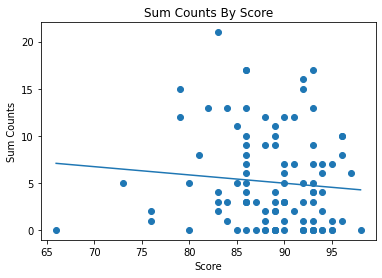

R value for Total Rhetorical Terms is -0.09292024612054116


In [30]:
#Check if amount of all term usage is indicative of grade
#Based on results, there is little relationship between amount of rhetorical terms used and grade...at least between A and B range essays)

#Create arrays of independent (x) and dependent (y) variables
x = np.array(rhetorical_keywords_df_full_texts['Portfolio_Score'])
y = np.array(rhetorical_keywords_df_full_texts['Sum_Terms'])

#Return key values of linear regression
slope, intercept, r, p, std_err = stats.linregress(x, y)

#Create function to return new equation
def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))

plt.scatter(x, y)
plt.plot(x, mymodel)
plt.title("Sum Counts By Score")
plt.xlabel("Score")
plt.ylabel("Sum Counts")
plt.show()

print("R value for Total Rhetorical Terms is " + str(r))

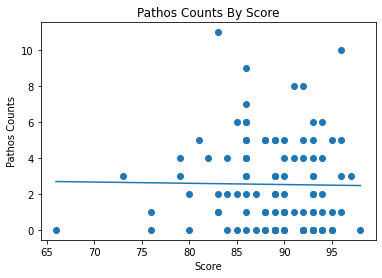

R value for Pathos is -0.014954740216191613


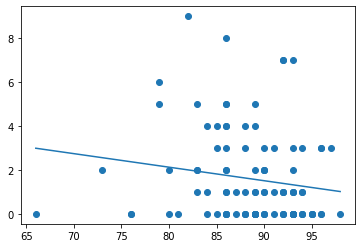

R value for Logos is -0.15889166613748085


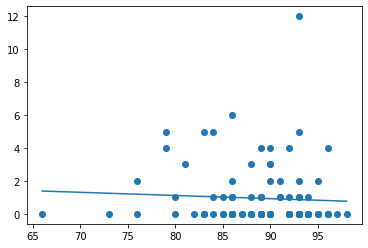

R value for Ethos is -0.05636829268152801


In [28]:
#Check if amount of usages of pathos is indicative of grade
#Create arrays of independent (x) and dependent (y) variables
x = np.array(rhetorical_keywords_df_full_texts['Portfolio_Score'])
y = np.array(rhetorical_keywords_df_full_texts['Pathos_Counts'])

#Return key values of linear regression
slope, intercept, r, p, std_err = stats.linregress(x, y)

#Create function to return new equation
def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))

plt.scatter(x, y)
plt.plot(x, mymodel)
plt.title("Pathos Counts By Score")
plt.xlabel("Score")
plt.ylabel("Pathos Counts")
plt.show()

print("R value for Pathos is " + str(r))


#Check if amount of usages of logos is indicative of grade
#Create arrays of independent (x) and dependent (y) variables
x = np.array(rhetorical_keywords_df_full_texts['Portfolio_Score'])
y = np.array(rhetorical_keywords_df_full_texts['Logos_Counts'])


#Return key values of linear regression
slope, intercept, r, p, std_err = stats.linregress(x, y)

#Create function to return new equation
def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))

plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()

print("R value for Logos is " + str(r))


#Check if amount of usages of ethos is indicative of grade
#Create arrays of independent (x) and dependent (y) variables
x = np.array(rhetorical_keywords_df_full_texts['Portfolio_Score'])
y = np.array(rhetorical_keywords_df_full_texts['Ethos_Counts'])


#Return key values of linear regression
slope, intercept, r, p, std_err = stats.linregress(x, y)

#Create function to return new equation
def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))

plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()

print("R value for Ethos is " + str(r))

### Segment Texts Into Paragraphs and Count Key Term Usages

In [38]:
#We only need one newlines version here
paragraphs_df = rhetorical_keywords_df_full_texts[['Portfolio_Score','Score_ID', 'Text_Newlines']].copy()

#Check new df
paragraphs_df.head()


,Portfolio_Score,Score_ID,Text_Newlines
5,66.0,"Score: 66.0, ID:199773",Liam A. Hart\nMegan Kane\nAnalytical Reading a...
13,73.0,"Score: 73.0, ID:202621",Paper 1 \n\nMichelle McCarthy\nProfessor Megan...
37,76.0,"Score: 76.0, ID:157620",Stacey Brizard \n\nDr Megan Kane\n\nEng 802\n\...
42,76.0,"Score: 76.0, ID:158545",Page 1\n\n\nFinal reflection\n\n\nKowalski\n\n...
38,79.0,"Score: 79.0, ID:186448",Thomas Butts\nAnalytical Reading and Writing\n...


In [39]:
#Count number of paragraphs in each text
paragraph_counts = paragraphs_df['Text_Newlines'].str.count(r'\n')
paragraph_counts

#Append paragraphs counts to dataframe
paragraphs_df["Paragraph_Counts"] = paragraph_counts
paragraphs_df

,Portfolio_Score,Score_ID,Text_Newlines,Paragraph_Counts
5,66.0,"Score: 66.0, ID:199773",Liam A. Hart\nMegan Kane\nAnalytical Reading a...,110
13,73.0,"Score: 73.0, ID:202621",Paper 1 \n\nMichelle McCarthy\nProfessor Megan...,129
37,76.0,"Score: 76.0, ID:157620",Stacey Brizard \n\nDr Megan Kane\n\nEng 802\n\...,232
42,76.0,"Score: 76.0, ID:158545",Page 1\n\n\nFinal reflection\n\n\nKowalski\n\n...,323
38,79.0,"Score: 79.0, ID:186448",Thomas Butts\nAnalytical Reading and Writing\n...,62
...,...,...,...,...
92,96.0,"Score: 96.0, ID:225111",Cam McWilliams \nProfessor Megan Kane\nENG 080...,82
93,96.0,"Score: 96.0, ID:214736",Allanah Nelligan\nMegan Kane\nEng 0802\n25 Apr...,58
94,96.0,"Score: 96.0, ID:227737",Morgan Owen Professor Megan Kane English 0802\...,194
89,97.0,"Score: 97.0, ID:230811",Sakshi Gawde Professor Kane ENG 0802\n30 Janua...,110


In [40]:
#Make new cell each time new paragraph starts 
new = paragraphs_df["Text_Newlines"].str.split(r'\n', expand = True).set_index(paragraphs_df['Score_ID'])

#Flatten dataframe so each chapter is on own row, designated by book and chapter 
paragraphs_df = new.stack().reset_index()
paragraphs_df.columns = ["Score_ID", "Paragraph", "Text"]
paragraphs_df

,Score_ID,Paragraph,Text
0,"Score: 66.0, ID:199773",0,Liam A. Hart
1,"Score: 66.0, ID:199773",1,Megan Kane
2,"Score: 66.0, ID:199773",2,Analytical Reading and Writing
3,"Score: 66.0, ID:199773",3,04/26/2021
4,"Score: 66.0, ID:199773",4,Final Portfolio
...,...,...,...
15893,"Score: 98.0, ID:156676",131,"Hensby, Alexander. Open networks and secret Fa..."
15894,"Score: 98.0, ID:156676",132,
15895,"Score: 98.0, ID:156676",133,"Ko, Ryan. “Meet 'Sara', 'Sharon' and 'Mel': Wh..."
15896,"Score: 98.0, ID:156676",134,


In [41]:
##Clean paragraphs
##Filter out paragraphs with 5 or less words (headers)
paragraphs_df = paragraphs_df[~paragraphs_df['Text'].str.split().str.len().lt(10)]

## Filter out paragraphs containing "http://", "doi:" , "https://" and "://www" (Works Cited citations)
paragraphs_df = paragraphs_df[~paragraphs_df['Text'].str.contains("http://")]

paragraphs_df = paragraphs_df[~paragraphs_df['Text'].str.contains("https://")]

paragraphs_df = paragraphs_df[~paragraphs_df['Text'].str.contains("://www")]

paragraphs_df = paragraphs_df[~paragraphs_df['Text'].str.contains("www.")]

paragraphs_df = paragraphs_df[~paragraphs_df['Text'].str.contains(".com/")]

paragraphs_df = paragraphs_df[~paragraphs_df['Text'].str.contains("Vol.")]

paragraphs_df = paragraphs_df[~paragraphs_df['Text'].str.contains("doi:")]

In [ ]:
#Save new df to csv and download to clean further
#paragraphs_df.to_csv('paragraphs.csv') 
#files.download('paragraphs.csv')

In [42]:
##Set up new dataframe for keyword frequency counts
rhetorical_keywords_paragraphs_df = paragraphs_df.copy()

#Count number of occurences of rhetorical terms in each paper
pathos_counts = rhetorical_keywords_paragraphs_df['Text'].str.count('pathos')
ethos_counts = rhetorical_keywords_paragraphs_df['Text'].str.count('ethos')
logos_counts = rhetorical_keywords_paragraphs_df['Text'].str.count('logos')

#Append each count to the dataframe
rhetorical_keywords_paragraphs_df['Pathos_Counts'] = pathos_counts
rhetorical_keywords_paragraphs_df["Ethos_Counts"] = ethos_counts
rhetorical_keywords_paragraphs_df["Logos_Counts"] = logos_counts

#Get summ of all term usages
rhetorical_terms = ['Pathos_Counts', 'Ethos_Counts', 'Logos_Counts']
rhetorical_keywords_paragraphs_df['Sum_Terms'] = rhetorical_keywords_paragraphs_df[rhetorical_terms].sum(axis=1)

rhetorical_keywords_paragraphs_df

,Score_ID,Paragraph,Text,Pathos_Counts,Ethos_Counts,Logos_Counts,Sum_Terms
5,"Score: 66.0, ID:199773",5,"Throughout this semester, I have learned a who...",0,0,0,0
6,"Score: 66.0, ID:199773",6,"Back in high school, I had a tough time writin...",0,0,0,0
7,"Score: 66.0, ID:199773",7,"Then came the junior year of high school, wher...",0,0,0,0
8,"Score: 66.0, ID:199773",8,When you are writing a letter to the United St...,0,0,0,0
9,"Score: 66.0, ID:199773",9,"Hopefully, this showed the readers what kind o...",0,0,0,0
...,...,...,...,...,...,...,...
15880,"Score: 98.0, ID:156676",118,"\tAs people, we have a lot of trouble dealing ...",0,0,0,0
15885,"Score: 98.0, ID:156676",123,Public attitudes toward political engagement ...,0,0,0,0
15888,"Score: 98.0, ID:156676",126,"Roberts, Siobhan. Who’s a Bot? Who’s Not?. The...",0,0,0,0
15891,"Score: 98.0, ID:156676",129,"Schulenberg, Jennifer L. Chenier, Allison. Int...",0,0,0,0


In [43]:
#Remove all rows with no rhetorical terms
rhetorical_keywords_paragraphs_df_no_blanks = rhetorical_keywords_paragraphs_df[rhetorical_keywords_paragraphs_df.Sum_Terms > 0]
rhetorical_keywords_paragraphs_df_no_blanks

,Score_ID,Paragraph,Text,Pathos_Counts,Ethos_Counts,Logos_Counts,Sum_Terms
119,"Score: 73.0, ID:202621",8,Orso’s Street Harassment in Philly talks about...,1,0,1,2
123,"Score: 73.0, ID:202621",12,\t Orso uses the rhetorical element pa...,1,0,0,1
125,"Score: 73.0, ID:202621",14,\tOrso also uses stories from women to...,1,0,0,1
127,"Score: 73.0, ID:202621",16,\tOrso use of statistics within logos ...,0,0,1,1
282,"Score: 76.0, ID:157620",41,\tWho would have thought even four centuries a...,0,1,0,1
...,...,...,...,...,...,...,...
15493,"Score: 96.0, ID:227737",37,Establishing pathos is not all that this anecd...,1,0,0,1
15660,"Score: 97.0, ID:230811",9,Orso’s use of anecdotes heightens the reader’s...,2,0,0,2
15666,"Score: 97.0, ID:230811",15,Quantifying data and numerical evidence create...,0,0,2,2
15667,"Score: 97.0, ID:230811",16,By writing the article heavily saturated in pe...,0,0,1,1


In [ ]:
#Save new df to csv and download
#rhetorical_keywords_df_no_blanks.to_csv('rhetorical_keywords_df_2.csv') 
#files.download('rhetorical_keywords_df_2.csv')

##5. Analyzing Term Count Frequencies


In [46]:
#Plot # paragraphs in which terms were used vs. essay grade?
##In other words, do more successful writers use terms in multiple paragrpahs (indicating more coherence)?

#Count number of paragraphs where terms used and append to new dataframe
new_Series = rhetorical_keywords_paragraphs_df_no_blanks['Score_ID'].value_counts(ascending=True)
df3 = pd.DataFrame(new_Series).reset_index()
df3

df3.rename(columns={"index": "Score_ID", "Score_ID": "Paragraph_Counts"}, errors="raise", inplace=True)
df3[['ID','Score']] = df3.Score_ID.str.split(", ",expand=True)

df3

#Plot paragraph counts per paper
fig = go.Figure(data=[
    go.Bar(name='Paragraph Counts', x=df3["Score_ID"], y=df3["Paragraph_Counts"]),

])
# Change the bar mode
fig.update_layout(title_text='Number of Paragraphs Where Rhetorical Terms Were Used')
fig.update_layout(barmode='stack', xaxis={'categoryorder':'category ascending'})
fig.show()

In [47]:
df3[['Score','ID']] = df3.Score_ID.str.split(", ",expand=True)
df3['Score'] = df3['Score'].map(lambda x: x.lstrip('Score: '))
df3 = df3[['Score','Paragraph_Counts']].copy()
df3 = df3.apply(pd.to_numeric)
df3

,Score,Paragraph_Counts
0,96.0,1
1,92.0,1
2,89.0,1
3,92.0,1
4,84.0,1
...,...,...
73,91.0,7
74,88.0,7
75,84.0,7
76,93.0,7


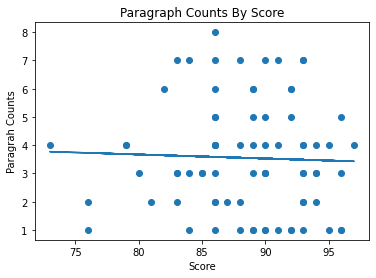

R value for Terms per Paragraph is -0.037004221734212014


In [48]:
#Check if amount of paragraph term usage is indicative of grade
#Based on results (r = .08, there is little relationship between amount of rhetorical terms used and grade...at least between A and B range essays)
from scipy import stats

#Check if amount of usages of all terms per paragraph is indicative of grade
#Create arrays of independent (x) and dependent (y) variables


x = np.array(df3['Score'])
y = np.array(df3['Paragraph_Counts'])

#Return key values of linear regression
slope, intercept, r, p, std_err = stats.linregress(x, y)

#Create function to return new equation
def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))

plt.scatter(x, y)
plt.plot(x, mymodel)
plt.title("Paragraph Counts By Score")
plt.xlabel("Score")
plt.ylabel("Paragrah Counts")
plt.show()

print("R value for Terms per Paragraph is " + str(r))

In [ ]:
rhetorical_keywords_df_no_blanks

In [ ]:
rhetorical_df_filtered = rhetorical_keywords_df[rhetorical_keywords_df['Paragraph'] < 50]

import plotly.express as px
fig = px.line(rhetorical_df_filtered, x='Paragraph', y='Sum_Terms', color='Score_ID', markers=True)
fig.update_layout(title_text='Term Usage by Paragraph (B-, C-Range, and D-Range Papers)')
fig.show()

##6. Get Collocates of Term Usages

In [ ]:
rhetorical_keywords_df_no_blanks

In [ ]:
#https://stackoverflow.com/questions/4664850/how-to-find-all-occurrences-of-a-substring
#Get position of all occurences of pathos
pathos_results = []
for text in rhetorical_keywords_df_no_blanks.Text:
  result = [m.start() for m in re.finditer('pathos', text)]
  pathos_results.append(result)

rhetorical_keywords_df_no_blanks['Pathos_Positions'] = pathos_results

#Get position of all occurences of ethos
ethos_results = []
for text in rhetorical_keywords_df_no_blanks.Text:
  result = [m.start() for m in re.finditer('ethos', text)]
  ethos_results.append(result)

rhetorical_keywords_df_no_blanks['Ethos_Positions'] = ethos_results

#Get position of all occurences of logos
logos_results = []
for text in rhetorical_keywords_df_no_blanks.Text:
  result = [m.start() for m in re.finditer('logos', text)]
  logos_results.append(result)

rhetorical_keywords_df_no_blanks['Logos_Positions'] = logos_results
rhetorical_keywords_df_no_blanks


##7. Get Rhetorical Term Synonyms 

### From Thesaurus

In [ ]:
#Get counts of synonym term usages in full texts
full_text_rhetorical_synonym_df = rhetorical_keywords_df_full_texts.copy()
full_text_rhetorical_synonym_df['Pathos_Synonyms'] = full_text_rhetorical_synonym_df['NoStops_Text'].str.count('experience|feel|stories|story|understand|compassion|passion|anecdote|sad|anger|sympathy|sympathetic|empathy|pity|fear*')
full_text_rhetorical_synonym_df['Logos_Synonyms'] = full_text_rhetorical_synonym_df['NoStops_Text'].str.count('logic|logical|reason|reasoning|statistic|statistics|fact|facts|data|common sense|evidence')
full_text_rhetorical_synonym_df['Ethos_Synonyms'] = full_text_rhetorical_synonym_df['NoStops_Text'].str.count('credible|credibility|authority|ethic|ethical|reliable|fair')
full_text_rhetorical_synonym_df['Rhetorical_Vocab'] = full_text_rhetorical_synonym_df['NoStops_Text'].str.count('audience|reader|context|situation|rhetorical|element|device|appeal|effective|argue|argument')

#Get summ of each type of term usages
pathos_terms = ['Pathos_Counts', 'Pathos_Synonyms']
full_text_rhetorical_synonym_df['Sum_Pathos_Terms'] = full_text_rhetorical_synonym_df[pathos_terms].sum(axis=1)

logos_terms = ['Logos_Counts', 'Logos_Synonyms']
full_text_rhetorical_synonym_df['Sum_Logos_Terms'] = full_text_rhetorical_synonym_df[logos_terms].sum(axis=1)

ethos_terms = ['Ethos_Counts', 'Ethos_Synonyms']
full_text_rhetorical_synonym_df['Sum_Ethos_Terms'] = full_text_rhetorical_synonym_df[ethos_terms].sum(axis=1)


#Get sum of all term usages
all_terms = ['Sum_Pathos_Terms', 'Sum_Ethos_Terms', 'Sum_Ethos_Terms', 'Rhetorical_Vocab']
full_text_rhetorical_synonym_df['Sum_All_Terms'] = full_text_rhetorical_synonym_df[all_terms].sum(axis=1)
full_text_rhetorical_synonym_df

In [ ]:
##Set up new dataframe for synonym frequency counts in paragraphs
rhetorical_synonym_df = rhetorical_keywords_df_no_blanks.copy()

In [ ]:
rhetorical_synonym_df['Pathos_Synonyms'] = rhetorical_synonym_df['Text'].str.count('experience|feel|stories|story|understand|compassion|passion|anecdote|sad|anger|sympathy|sympathetic|empathy|pity|fear*')
rhetorical_synonym_df['Logos_Synonyms'] = rhetorical_synonym_df['Text'].str.count('logic|logical|reason|reasoning|statistic|statistics|fact|facts|common sense|evidence')
rhetorical_synonym_df['Ethos_Synonyms'] = rhetorical_synonym_df['Text'].str.count('credible|credibility|authority|ethic|ethical|reliable|fair')
rhetorical_synonym_df['Rhetorical_Vocab'] = rhetorical_synonym_df['Text'].str.count('audience|reader|context|situation|rhetorical|element|device|appeal|effective|argue|argument')
rhetorical_synonym_df


In [ ]:
#Get summ of all term usages
pathos_terms = ['Pathos_Counts', 'Pathos_Synonyms']
rhetorical_synonym_df['Sum_Pathos_Terms'] = rhetorical_synonym_df[pathos_terms].sum(axis=1)

logos_terms = ['Logos_Counts', 'Logos_Synonyms']
rhetorical_synonym_df['Sum_Logos_Terms'] = rhetorical_synonym_df[logos_terms].sum(axis=1)

ethos_terms = ['Ethos_Counts', 'Ethos_Synonyms']
rhetorical_synonym_df['Sum_Ethos_Terms'] = rhetorical_synonym_df[ethos_terms].sum(axis=1)
rhetorical_synonym_df


#Get sum of all term usages
all_terms = ['Sum_Pathos_Terms', 'Sum_Ethos_Terms', 'Sum_Ethos_Terms', 'Rhetorical_Vocab']
rhetorical_synonym_df['Sum_All_Terms'] = rhetorical_synonym_df[all_terms].sum(axis=1)
rhetorical_synonym_df

In [ ]:
#Chart number of times each type of term was used in each essay 
#Create bar graph
#https://plotly.com/python/bar-charts/
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Sum_Pathos_Terms', x=rhetorical_synonym_df["Score_ID"], y=rhetorical_synonym_df["Sum_Pathos_Terms"]),
    go.Bar(name='Sum_Ethos_Terms', x=rhetorical_synonym_df["Score_ID"], y=rhetorical_synonym_df["Sum_Ethos_Terms"]),
    go.Bar(name='Sum_Logos_Terms', x=rhetorical_synonym_df["Score_ID"], y=rhetorical_synonym_df["Sum_Logos_Terms"]),
    go.Bar(name='Sum_Rhetorical_Vocab', x=rhetorical_synonym_df["Score_ID"], y=rhetorical_synonym_df["Rhetorical_Vocab"])

])


# Change the bar mode
fig.update_layout(title_text='Counts of Each Type of Rhetorical Term in Each Essay')
fig.update_layout(barmode='stack')
fig.show()

In [ ]:
#Create new df for numerical values for regression calculations
rhetorical_regression_df = rhetorical_synonym_df[['Score','Sum_Pathos_Terms',	'Sum_Ethos_Terms',	'Sum_Logos_Terms','Sum_All_Terms', 'Rhetorical_Vocab']].copy()
rhetorical_regression_df = rhetorical_regression_df.apply(pd.to_numeric) 
rhetorical_regression_df

In [ ]:
#Check if amount of usages of pathos is indicative of grade
#Create arrays of independent (x) and dependent (y) variables
x = np.array(rhetorical_regression_df['Score'])
y = np.array(rhetorical_regression_df['Sum_Pathos_Terms'])

#Return key values of linear regression
slope, intercept, r, p, std_err = stats.linregress(x, y)

#Create function to return new equation
def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))

plt.scatter(x, y)
plt.plot(x, mymodel)
plt.title("Pathos Counts By Score")
plt.xlabel("Score")
plt.ylabel("Pathos Counts")
plt.show()

print("R value for Pathos is " + str(r))


#Check if amount of usages of logos is indicative of grade
#Create arrays of independent (x) and dependent (y) variables
x = np.array(rhetorical_regression_df['Score'])
y = np.array(rhetorical_regression_df['Sum_Logos_Terms'])


#Return key values of linear regression
slope, intercept, r, p, std_err = stats.linregress(x, y)

#Create function to return new equation
def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))

plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()

print("R value for Logos is " + str(r))


#Check if amount of usages of ethos is indicative of grade
#Create arrays of independent (x) and dependent (y) variables
x = np.array(rhetorical_regression_df['Score'])
y = np.array(rhetorical_regression_df['Sum_Ethos_Terms'])


#Return key values of linear regression
slope, intercept, r, p, std_err = stats.linregress(x, y)

#Create function to return new equation
def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))

plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()

print("R value for Ethos is " + str(r))


#Check if amount of rhetorical term usages is indicative of grade
#Create arrays of independent (x) and dependent (y) variables
x = np.array(rhetorical_regression_df['Score'])
y = np.array(rhetorical_regression_df['Rhetorical_Vocab'])


#Return key values of linear regression
slope, intercept, r, p, std_err = stats.linregress(x, y)

#Create function to return new equation
def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))

plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()

print("R value for Rhetorical Vocab is " + str(r))


#Check if amount of all term usages is indicative of grade
#Create arrays of independent (x) and dependent (y) variables
x = np.array(rhetorical_regression_df['Score'])
y = np.array(rhetorical_regression_df['Sum_All_Terms'])


#Return key values of linear regression
slope, intercept, r, p, std_err = stats.linregress(x, y)

#Create function to return new equation
def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))

plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()

print("R value for All Terms is " + str(r))

### Word2Vec

In [ ]:
#Create new dataframe for word2vec
word2vec_essays = essays_grades_master[['ID', 'Portfolio_Score', 'NoStops_Text']].copy()
word2vec_essays

#Split dataframe into three groups based on grades
low = 83
high = 93
c_range = word2vec_essays[word2vec_essays['Portfolio_Score'] <= low]
b_range = word2vec_essays[word2vec_essays['Portfolio_Score'] > low]
b_range = b_range[word2vec_essays['Portfolio_Score'] <= high]
a_range = word2vec_essays[word2vec_essays['Portfolio_Score'] > high]

#### Word2Vec on A Range Essays

In [ ]:
#Define spaCy function to lemmatize, remove stopwords and non-alphanumeric characters
nlp = spacy.load('en_core_web_sm')

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [ ]:
#Remove characters
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in a_range['NoStops_Text'])
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]

#Put results in a new dataframe
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

In [ ]:
#Use bigrams to detect common phrases
from gensim.models.phrases import Phrases, Phraser

#Take list of list of words as input
sent = [row.split() for row in df_clean['clean']]

#Creates relevant list of phrases from all sentences
phrases = Phrases(sent, min_count=30, progress_per=10000)
bigram = Phraser(phrases)

#Transform the corpus based on the bigrams detected:
sentences = bigram[sent]

In [ ]:
#Count word frequency
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

In [ ]:
#Get most frequent words
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

In [ ]:
#Import word2vec
import multiprocessing

from gensim.models import Word2Vec

cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [ ]:
#Build word2vecmodel (check how to set parameters in tutorial)
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [ ]:
#Build vocab table--digest all words, filter out unique words, do counts on them
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
#Set parameters to train the model
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
#Now that the model has been trained, make it more memory efficient
w2v_model.init_sims(replace=True)

In [ ]:
#Find most similar words to pathos in a-range essays
w2v_model.wv.most_similar(positive=["pathos"])

In [ ]:
#Find most similar words to key terms in corpus
w2v_model.wv.most_similar(positive=["ethos"])

In [ ]:
#Find most similar words to key terms in corpus
#I think I cleaned logos out of the corpus accidentally! Only "logo" shows up
w2v_model.wv.most_similar(positive=["logo"])

In [ ]:
#Check similarity between words
w2v_model.wv.similarity("pathos", 'logo')

In [ ]:
#Analogy difference
w2v_model.wv.most_similar(positive=["pathos", "logo"], negative=["emotion"], topn=3)

#### Word2Vec on B Range Essays

In [ ]:
#Define spaCy function to lemmatize, remove stopwords and non-alphanumeric characters
nlp = spacy.load('en_core_web_sm')

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [ ]:
#Remove characters
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in b_range['NoStops_Text'])
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]

#Put results in a new dataframe
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

In [ ]:
#Use bigrams to detect common phrases
from gensim.models.phrases import Phrases, Phraser

#Take list of list of words as input
sent = [row.split() for row in df_clean['clean']]

#Creates relevant list of phrases from all sentences
phrases = Phrases(sent, min_count=30, progress_per=10000)
bigram = Phraser(phrases)

#Transform the corpus based on the bigrams detected:
sentences = bigram[sent]

In [ ]:
#Count word frequency
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

In [ ]:
#Get most frequent words
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

In [ ]:
#Import word2vec
import multiprocessing

from gensim.models import Word2Vec

cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [ ]:
#Build word2vecmodel (check how to set parameters in tutorial)
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [ ]:
#Build vocab table--digest all words, filter out unique words, do counts on them
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
#Set parameters to train the model
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
#Now that the model has been trained, make it more memory efficient
w2v_model.init_sims(replace=True)

In [ ]:
#Find most similar words to key terms in corpus
w2v_model.wv.most_similar(positive=["pathos"])

In [ ]:
#Find most similar words to key terms in corpus
w2v_model.wv.most_similar(positive=["ethos"])

In [ ]:
#Find most similar words to key terms in corpus
#I think I cleaned logos out of the corpus accidentally! Only "logo" shows up
w2v_model.wv.most_similar(positive=["logo"])

In [ ]:
#Check similarity between words
w2v_model.wv.similarity("pathos", 'ethos')

In [ ]:
#Analogy difference
w2v_model.wv.most_similar(positive=["pathos", "ethos"], negative=["emotion"], topn=3)

#### Word2Vec on C Range Essays

In [ ]:
#Define spaCy function to lemmatize, remove stopwords and non-alphanumeric characters
nlp = spacy.load('en_core_web_sm')

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [ ]:
#Remove characters
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in c_range['NoStops_Text'])
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]

#Put results in a new dataframe
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

In [ ]:
#Use bigrams to detect common phrases
from gensim.models.phrases import Phrases, Phraser

#Take list of list of words as input
sent = [row.split() for row in df_clean['clean']]

#Creates relevant list of phrases from all sentences
phrases = Phrases(sent, min_count=30, progress_per=10000)
bigram = Phraser(phrases)

#Transform the corpus based on the bigrams detected:
sentences = bigram[sent]

In [ ]:
#Count word frequency
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

In [ ]:
#Get most frequent words
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

In [ ]:
#Import word2vec
import multiprocessing

from gensim.models import Word2Vec

cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [ ]:
#Build word2vecmodel (check how to set parameters in tutorial)
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [ ]:
#Build vocab table--digest all words, filter out unique words, do counts on them
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
#Set parameters to train the model
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
#Now that the model has been trained, make it more memory efficient
w2v_model.init_sims(replace=True)

In [ ]:
#Find most similar words to key terms in corpus of c-range essays
w2v_model.wv.most_similar(positive=["pathos"])

In [ ]:
#Find most similar words to key terms in corpus
w2v_model.wv.most_similar(positive=["ethos"])

In [ ]:
#Find most similar words to key terms in corpus
#I think I cleaned logos out of the corpus accidentally! Only "logo" shows up
w2v_model.wv.most_similar(positive=["logo"])

In [ ]:
#Check similarity between words
w2v_model.wv.similarity("pathos", 'ethos')

In [ ]:
#Analogy difference
w2v_model.wv.most_similar(positive=["pathos", "ethos"], negative=["emotion"], topn=3)

##8. Principal Component Analysis: Rhetorical Terms
https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

###Full Texts (Term Counts)

In [ ]:
#Retrive essay grades master dataframe
rhetorical_keywords_df_full_texts.head()

In [ ]:
#Get identifying data (scores and filenames)
targets = rhetorical_keywords_df_full_texts.copy()
targets = targets.drop(['ID', 'Section', 'Text_Newlines', 'NoStops_Text', 'Score_ID'], axis=1)

#Sort by grade
targets.sort_values(by=['Portfolio_Score'], inplace=True)

targets

In [ ]:
#Create new column to label essays based on grade range
def calc_new_col(row):
  if row['Portfolio_Score'] <= 80:
     return 'Low-Scoring'
  if row['Portfolio_Score'] >= 95:
     return 'High-Scoring'
  else:
    return 'Mid-Scoring'

targets["Range"] = targets.apply(calc_new_col, axis=1)

targets

In [ ]:
#Drop unnecessary columns
PCA_df = targets.drop(["Filename", "Portfolio_Score"], axis=1)

# shift column 'Range' to first position
first_column = PCA_df.pop('Range')
  
# insert column using insert(position,column_name,
# first_column) function
PCA_df.insert(0, 'Range', first_column)

PCA_df.head()

In [ ]:
#Separate the features from the target
# Separating out the target
y = PCA_df.loc[:,['Range']].values

# Separating out the features
PCA_df_2 = PCA_df.drop(["Range"], axis=1)
x = PCA_df_2.values

# Standardizing the features
from sklearn.preprocessing import StandardScaler
x = StandardScaler().fit_transform(x)

In [ ]:
#Project to 2D via principal component analysis
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf

In [ ]:
#Concatenate with the range values
finalDf = pd.concat([principalDf, PCA_df[['Range']]], axis = 1)

In [ ]:
#Plot PCA results
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Low-Scoring', 'Mid-Scoring', 'High-Scoring']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Range'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
#Get the explained variance ratio
pca.explained_variance_ratio_

###Full Texts (DocuScope)

In [ ]:
#Retrive essay grades master dataframe
essays_grades_master.head()

In [ ]:
#Get identifying data (scores and filenames)
targets = essays_grades_master[['Filename','Portfolio_Score']]

#Sort by grade
targets.sort_values(by=['Portfolio_Score'], inplace=True)

targets

In [ ]:
#Create new column to label essays based on grade range
def calc_new_col(row):
  if row['Portfolio_Score'] <= 83:
     return 'Low-Scoring'
  if row['Portfolio_Score'] >= 94:
     return 'High-Scoring'
  else:
    return 'Mid-Scoring'

targets["Range"] = targets.apply(calc_new_col, axis=1)

targets

In [ ]:
#Upload csv with LAT data
uploaded_LATS = files.upload()

In [ ]:
lats_df = pd.read_csv('CLUSTER_C_CITATIONS_TERMS_ARGUMENTS.csv')
lats_df

In [ ]:
#Merge target and LAT tables based ono filename
PCA_df = pd.merge(targets, lats_df, on='Filename')

#Drop unnecessary columns
PCA_df = PCA_df.drop(["Filename", "Portfolio_Score", "Tokens", "Group"], axis=1)
PCA_df.head()

In [ ]:
#Separate the features from the target
# Separating out the target
y = PCA_df.loc[:,['Range']].values

# Separating out the features
PCA_df_2 = PCA_df.drop(["Range"], axis=1)
x = PCA_df_2.values

# Standardizing the features
from sklearn.preprocessing import StandardScaler
x = StandardScaler().fit_transform(x)

In [ ]:
#Project to 2D via principal component analysis
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf

In [ ]:
#Concatenate with the range values
finalDf = pd.concat([principalDf, PCA_df[['Range']]], axis = 1)

In [ ]:
#Plot PCA results
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Low-Scoring', 'Mid-Scoring', 'High-Scoring']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Range'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
#Get the explained variance ratio
pca.explained_variance_ratio_

###Full Texts (DocuScope and Term Counts)

In [ ]:
#Retrive essay grades master dataframe
rhetorical_keywords_df_full_texts.head()

In [ ]:
#Get identifying data (scores and filenames)
targets = rhetorical_keywords_df_full_texts.copy()
targets = targets.drop(['ID', 'Section', 'Text_Newlines', 'NoStops_Text', 'Score_ID'], axis=1)


#Sort by grade
targets.sort_values(by=['Portfolio_Score'], inplace=True)

targets

In [ ]:
#Create new column to label essays based on grade range
def calc_new_col(row):
  if row['Portfolio_Score'] <= 83:
     return 'Low-Scoring'
  if row['Portfolio_Score'] >= 95:
     return 'High-Scoring'
  else:
    return 'Mid-Scoring'

targets["Range"] = targets.apply(calc_new_col, axis=1)

targets

In [ ]:
#Upload csv with LAT data
uploaded_LATS = files.upload()

In [ ]:
select_clusters_df = pd.read_csv('CLUSTER_C_CITATIONS_TERMS_ARGUMENTS.csv')
select_clusters_df

In [ ]:
#Merge target and LAT tables based ono filename
PCA_df = pd.merge(targets, select_clusters_df, on='Filename')

#Drop unnecessary columns
PCA_df = PCA_df.drop(["Filename", "Portfolio_Score", "Tokens"], axis=1)

# shift column 'Range' to first position
first_column = PCA_df.pop('Range')
  
# insert column using insert(position,column_name,
# first_column) function
PCA_df.insert(0, 'Range', first_column)
PCA_df.head()

In [ ]:
#Separate the features from the target
# Separating out the target
y = PCA_df.loc[:,['Range']].values

# Separating out the features
PCA_df_2 = PCA_df.drop(["Range"], axis=1)
x = PCA_df_2.values

# Standardizing the features
from sklearn.preprocessing import StandardScaler
x = StandardScaler().fit_transform(x)

In [ ]:
#Project to 2D via principal component analysis
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf

In [ ]:
#Concatenate with the range values
finalDf = pd.concat([principalDf, PCA_df[['Range']]], axis = 1)

In [ ]:
#Plot PCA results
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Low-Scoring','High-Scoring']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Range'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
#Get the explained variance ratio
pca.explained_variance_ratio_

### All Essay Paragraphs (DocuScope)

In [ ]:
rhetorical_keywords_df

In [ ]:
#Rename filename column to make filenaming easier later
rhetorical_keywords_df['Filename_Label'] = rhetorical_keywords_df['Filename'].astype(str) + "_Paragraph_" + rhetorical_keywords_df['Paragraph'].astype(str) + '.txt'
rhetorical_keywords_df.head()

In [ ]:
paragraph_PCA_texts = rhetorical_keywords_df[['Filename_Label', 'Text', 'Score', "Pathos_Counts","Ethos_Counts","Logos_Counts","Sum_Terms"]]
paragraph_PCA_texts

In [ ]:
#Add each text to a new list called paragraph_context
paragraph_context = []
for row in paragraph_PCA_texts['Text'].items():
    row_string = (str(row[1]))
    paragraph_context.append(row_string)

#Add filenames to list
filenames = []
for row in paragraph_PCA_texts['Filename_Label'].items():
    row_string = (str(row[1]))
    filenames.append(row_string)

filenames[1]

In [ ]:
#Make new directory to store text files
!mkdir paragraph_context

#Write texts to files
n = 0
for item in paragraph_context:
  f = open("paragraph_context/" + filenames[n],'w')
  n= n+1
  f.write(item)
  f.close()


In [ ]:
#Zip text files in folder
!zip -r paragraph_context.zip paragraph_context

#Download file to zip folder to run through DocuScope
files.download('paragraph_context.zip')

In [ ]:
#Get identifying data (scores and filenames)
paragraph_targets = paragraph_PCA_texts[['Filename_Label','Score']]
paragraph_targets['Score'] = paragraph_targets['Score'].astype(float)

#Sort by grade
paragraph_targets.sort_values(by=['Score'], inplace=True)

#Create new column to label essays based on grade range
def calc_new_col(row):
  if row['Score'] <= 80:
     return 'Low-Scoring'
  if row['Score'] >= 90:
     return 'High-Scoring'
  else:
    return 'Mid-Scoring'

paragraph_targets["Range"] = paragraph_targets.apply(calc_new_col, axis=1)

paragraph_targets

In [ ]:
#Upload csv with LAT data
uploaded_LATS_paragraphs = files.upload()

In [ ]:
paragraph_lats_df = pd.read_csv('CLUSTER_N_essay_paragraphs.csv')
paragraph_lats_df.rename(columns={"Filename": "Filename_Label"}, inplace=True)

paragraph_lats_df

In [ ]:
paragraph_targets

In [ ]:
#Merge target and LAT tables based ono filename
paragraph_PCA_df = pd.merge(paragraph_targets, paragraph_lats_df, on='Filename_Label')

paragraph_PCA_df

In [ ]:
#Drop unnecessary columns
paragraph_PCA_df = paragraph_PCA_df.drop(["Filename_Label", "Score", "Tokens", "Group"], axis=1)

paragraph_PCA_df

In [ ]:
#Separate the features from the target
# Separating out the target
y = paragraph_PCA_df.loc[:,['Range']].values

# Separating out the features
paragraph_PCA_df2 = paragraph_PCA_df.drop(["Range"], axis=1)
x = paragraph_PCA_df2.values

# Standardizing the features
from sklearn.preprocessing import StandardScaler
x = StandardScaler().fit_transform(x)

In [ ]:
#Project to 2D via principal component analysis
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
paragraph_principalComponents = pca.fit_transform(x)
paragraph_principalDf = pd.DataFrame(data = paragraph_principalComponents
             , columns = ['principal component 1', 'principal component 2'])
paragraph_principalDf.head()

In [ ]:
#Concatenate with the range values
paragraph_finalDf = pd.concat([paragraph_principalDf, paragraph_PCA_df[['Range']]], axis = 1)
paragraph_finalDf.head()

In [ ]:
#Plot PCA results
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Low-Scoring', 'Mid-Scoring', 'High-Scoring']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = paragraph_finalDf['Range'] == target
    ax.scatter(paragraph_finalDf.loc[indicesToKeep, 'principal component 1']
               , paragraph_finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
#Get the explained variance ratio
pca.explained_variance_ratio_

### Rhetorical Context Paragraphs (DocuScope and Term Counts)

In [ ]:
rhetorical_keywords_df_no_blanks.head()

In [ ]:
#Rename filename column to make filenaming easier later
rhetorical_keywords_df_no_blanks['Filename_Label'] = rhetorical_keywords_df_no_blanks['Filename'].astype(str) + "_Paragraph_" + rhetorical_keywords_df_no_blanks['Paragraph'].astype(str) + '.txt'
rhetorical_keywords_df_no_blanks.head()

In [ ]:
rhet_PCA_texts = rhetorical_keywords_df_no_blanks[['Filename_Label', 'Text', 'Score', "Pathos_Counts","Ethos_Counts","Logos_Counts","Sum_Terms"]]
rhet_PCA_texts

In [ ]:
#Add each text to a new list called rhet_context
rhet_context = []
for row in paragraph_PCA_texts['Text'].items():
    row_string = (str(row[1]))
    rhet_context.append(row_string)

#Add filenames to list
filenames = []
for row in rhet_PCA_texts['Filename_Label'].items():
    row_string = (str(row[1]))
    filenames.append(row_string)

filenames[1]

In [ ]:
#Make new directory to store text files
!mkdir rhet_context

#Write texts to files
n = 0
for item in rhet_context:
  f = open("rhet_context/" + filenames[n],'w') #Generates an error but still works
  n= n+1
  f.write(item)
  f.close()

In [ ]:
#Zip text files in folder
!zip -r rhet_context.zip rhet_context

#Download file to zip folder to run through DocuScope
files.download('rhet_context.zip')

In [ ]:
rhet_PCA_texts

In [ ]:
#Get identifying data (scores and filenames)
rhet_targets = rhet_PCA_texts[['Filename_Label','Score', 'Pathos_Counts', 'Ethos_Counts', 'Logos_Counts', 'Sum_Terms']]
rhet_targets['Score'] = rhet_targets['Score'].astype(float)

#Sort by grade
rhet_targets.sort_values(by=['Score'], inplace=True)

#Create new column to label essays based on grade range
def calc_new_col(row):
  if row['Score'] <= 83:
     return 'Low-Scoring'
  if row['Score'] >= 94:
     return 'High-Scoring'
  else:
    return 'Mid-Scoring'

rhet_targets["Range"] = rhet_targets.apply(calc_new_col, axis=1)

rhet_targets

In [ ]:
#Upload csv with LAT data
uploaded_LATS_paragraphs = files.upload()

In [ ]:
rhet_lats_df = pd.read_csv('CLUSTER_N_rhet_context.csv')
rhet_lats_df.rename(columns={"Filename": "Filename_Label"}, inplace=True)

rhet_lats_df

In [ ]:
rhet_targets

In [ ]:
#Merge target and LAT tables based ono filename
rhet_PCA_df = pd.merge(rhet_targets, rhet_lats_df, on='Filename_Label')

rhet_PCA_df

In [ ]:
#Drop unnecessary columns
rhet_PCA_df = rhet_PCA_df.drop(["Filename_Label", "Score", "Tokens", "Group"], axis=1)

# shift column 'Range' to first position
first_column = rhet_PCA_df.pop('Range')
  
# insert column using insert(position,column_name,
# first_column) function
rhet_PCA_df.insert(0, 'Range', first_column)

rhet_PCA_df

In [ ]:
#Separate the features from the target
# Separating out the target
y = rhet_PCA_df.loc[:,['Range']].values

# Separating out the features
rhet_PCA_df2 = rhet_PCA_df.drop(["Range"], axis=1)
x = rhet_PCA_df2.values

# Standardizing the features
from sklearn.preprocessing import StandardScaler
x = StandardScaler().fit_transform(x)

In [ ]:
#Project to 2D via principal component analysis
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
rhet_principalComponents = pca.fit_transform(x)
rhet_principalDf = pd.DataFrame(data = rhet_principalComponents
             , columns = ['principal component 1', 'principal component 2'])
rhet_principalDf.head()

In [ ]:
#Concatenate with the range values
rhet_finalDf = pd.concat([rhet_principalDf, rhet_PCA_df[['Range']]], axis = 1)
rhet_finalDf.head()

In [ ]:
#Plot PCA results
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Low-Scoring', 'Mid-Scoring', 'High-Scoring']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = rhet_finalDf['Range'] == target
    ax.scatter(rhet_finalDf.loc[indicesToKeep, 'principal component 1']
               , rhet_finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

###Example

In [ ]:
#Create new dataframe for PCA
PCA_essays = essays_grades_master[['ID', 'Portfolio_Score', 'NoStops_Text']].copy()
PCA_essays

In [ ]:
import pandas as pd
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
# load dataset into Pandas DataFrame
df = pd.read_csv(url, names=['sepal length','sepal width','petal length','petal width','target'])

from sklearn.preprocessing import StandardScaler
features = ['sepal length', 'sepal width', 'petal length', 'petal width']
# Separating out the features
x = df.loc[:, features].values
# Separating out the target
y = df.loc[:,['target']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])


finalDf = pd.concat([principalDf, df[['target']]], axis = 1)
finalDf

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
pca.explained_variance_ratio_


## 9. Extract Keywords and Context: Source Engagement

#### Extracting Citations

In [ ]:
#Retrive essay grades master dataframe
essays_grades_master.head()

In [ ]:
#Get any text inside parentheticals and count of parentheticals and append to dataframe
#https://stackoverflow.com/questions/24696715/regex-for-match-parentheses-in-python
parentheticals = r'(?<=\().*?(?=\))'

parenthetical_matches = []
parenthetical_counts = []

citation_df = essays_grades_master[['Filename','ID', 'Portfolio_Score', 'Text']].copy()
for text in citation_df['Text']:
  matches = re.findall(parentheticals, text)
  parenthetical_matches.append(matches)
  parenthetical_counts.append(len(matches))

citation_df["Parentheticals"] = parenthetical_matches
citation_df['Parenthetical_Counts'] = parenthetical_counts
citation_df

In [ ]:
#Add ID and score in one column
citation_df['Score_ID'] = 'Score: ' + citation_df['Portfolio_Score'].astype(str) + ', ID:' + citation_df['ID'].astype(str)

In [ ]:
#Chart number of times parentheticals were used in each essay 
#Create bar graph
#https://plotly.com/python/bar-charts/
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Parenthetical_Tags', x=citation_df["Score_ID"], y=citation_df["Parenthetical_Counts"])
])
# Change the bar mode
fig.update_layout(title_text='Counts of Parentheticals Used in Each Essay')
fig.update_layout(barmode='stack')
fig.show()

In [ ]:
#Regression: Parentheticals vs. Grade

#Check if amount of all term usage is indicative of grade
#Based on results (r = .08, there is little relationship between amount of rhetorical terms used and grade...at least between A and B range essays)
from scipy import stats


#Create arrays of independent (x) and dependent (y) variables
x = np.array(citation_df['Portfolio_Score'])
y = np.array(citation_df['Parenthetical_Counts'])

#Return key values of linear regression
slope, intercept, r, p, std_err = stats.linregress(x, y)

#Create function to return new equation
def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))

plt.scatter(x, y)
plt.plot(x, mymodel)
plt.title("Parenthetical Counts By Score")
plt.xlabel("Score")
plt.ylabel("Parenthetical Counts")
plt.show()

print("R value for Parentheticals is " + str(r))


### DocuScope Citation Dimensions Plots and Regression

In [ ]:
#Upload csv with LAT data
uploaded_LATS = files.upload()

In [ ]:
lats_df = pd.read_csv('Citation_Cluster_Dimension_N.csv')
lats_df

In [ ]:
#Merge target and LAT tables based ono filename
merged_lat_df = pd.merge(targets, lats_df, on='Filename')

#Add ID and score in one column
merged_lat_df['Score_ID'] = 'Score: ' + merged_lat_df['Portfolio_Score'].astype(str) + ', ID:' + merged_lat_df['ID'].astype(str)

merged_lat_df.head()

In [ ]:
#Chart number of times all terms were used in each essay 
#Create bar graph
#https://plotly.com/python/bar-charts/
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Citations_Tags', x=merged_lat_df["Score_ID"], y=merged_lat_df["Citation_Cluster"])
])
# Change the bar mode
fig.update_layout(title_text='Counts of All Citation Cluster Terms Used in Each Essay')
fig.update_layout(barmode='stack')
fig.show()

In [ ]:
#Regression: Citation vs. Grade

#Check if amount of all term usage is indicative of grade
#Based on results (r = .08, there is little relationship between amount of rhetorical terms used and grade...at least between A and B range essays)
from scipy import stats


#Create arrays of independent (x) and dependent (y) variables
x = np.array(merged_lat_df['Portfolio_Score'])
y = np.array(merged_lat_df['Citation_Cluster'])

#Return key values of linear regression
slope, intercept, r, p, std_err = stats.linregress(x, y)

#Create function to return new equation
def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))

plt.scatter(x, y)
plt.plot(x, mymodel)
plt.title("Citation Counts By Score")
plt.xlabel("Score")
plt.ylabel("Citation Counts")
plt.show()

print("R value for Total Citation Terms is " + str(r))


In [ ]:
#Chart number of times each citation dimension was used in each essay 
#Create bar graph
#https://plotly.com/python/bar-charts/
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='CitationAuthority', x=merged_lat_df["Score_ID"], y=merged_lat_df["CitationAuthority"]),
    go.Bar(name='CitationControversy', x=merged_lat_df["Score_ID"], y=merged_lat_df["CitationControversy"]),
    go.Bar(name='CitationGeneric', x=merged_lat_df["Score_ID"], y=merged_lat_df["CitationGeneric"]),
    go.Bar(name='CitationHedged', x=merged_lat_df["Score_ID"], y=merged_lat_df["CitationHedged"]),
    go.Bar(name='CitationNegative', x=merged_lat_df["Score_ID"], y=merged_lat_df["CitationNegative"]),
    go.Bar(name='CitationNeutral', x=merged_lat_df["Score_ID"], y=merged_lat_df["CitationNeutral"]),
    go.Bar(name='CitationSpeakerLookMood', x=merged_lat_df["Score_ID"], y=merged_lat_df["CitationSpeakerLookMood"]),
    go.Bar(name='UncertainCitation', x=merged_lat_df["Score_ID"], y=merged_lat_df["UncertainCitation"]),

])


# Change the bar mode
fig.update_layout(title_text='Counts of Each Rhetorical Term in Each Essay')
fig.update_layout(barmode='stack')
fig.show()

####PCA with Full Texts (DocuScope Citation Dimensions)

In [ ]:
#Retrive essay grades master dataframe
essays_grades_master.head()

In [ ]:
#Get identifying data (scores and filenames)
targets = essays_grades_master[['Filename', 'ID', 'Portfolio_Score']]

#Sort by grade
targets.sort_values(by=['Portfolio_Score'], inplace=True)

targets

In [ ]:
#Create new column to label essays based on grade range
def calc_new_col(row):
  if row['Portfolio_Score'] <= 83:
     return 'Low-Scoring'
  if row['Portfolio_Score'] >= 94:
     return 'High-Scoring'
  else:
    return 'Mid-Scoring'

targets["Range"] = targets.apply(calc_new_col, axis=1)

targets

In [ ]:
#Upload csv with LAT data
uploaded_LATS = files.upload()


In [ ]:
citation_dimensions_df = pd.read_csv('DIMENSION_C_New Txt Submissions_CITATIONS.csv')
citation_dimensions_df

In [ ]:
#Merge target and LAT tables based ono filename
merged_lat_df = pd.merge(targets, citation_dimensions_df, on='Filename')

#Drop unnecessary columns
PCA_df = merged_lat_df.drop(["ID", "Filename", "Portfolio_Score", "Tokens"], axis=1)
PCA_df.head()

In [ ]:
#Separate the features from the target
# Separating out the target
y = PCA_df.loc[:,['Range']].values

# Separating out the features
PCA_df_2 = PCA_df.drop(["Range"], axis=1)
x = PCA_df_2.values

# Standardizing the features
from sklearn.preprocessing import StandardScaler
x = StandardScaler().fit_transform(x)

In [ ]:
#Project to 2D via principal component analysis
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf

In [ ]:
#Concatenate with the range values
finalDf = pd.concat([principalDf, PCA_df[['Range']]], axis = 1)

In [ ]:
#Plot PCA results
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Low-Scoring', 'Mid-Scoring', 'High-Scoring']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Range'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
#Get the explained variance ratio
pca.explained_variance_ratio_

## 10. Principal Component Analysis: Rhetorical Terms and Source Engagement

In [ ]:
#Drop unneeded columns from each dataframe
#DataFrame with all rhetorical term counts
rhetorical_keywords_df_full_texts_merge = rhetorical_keywords_df_full_texts.drop(['Score_ID', 'Text_Newlines', 'NoStops_Text', 'ID', "Section"], axis=1)
rhetorical_keywords_df_full_texts_merge

#DataFrame with parenthetical citations
citation_df_merge = citation_df.drop(['Score_ID', 'Text', 'Parentheticals', 'ID', 'Portfolio_Score'], axis=1)

#DataFrame with DocuScope citation dimensions
citation_dimensions_df_merge = citation_dimensions_df.drop(['Tokens'], axis = 1)

#DataFrame wtih select DocuScope clusters
select_clusters_df_merge = select_clusters_df.drop(['Tokens'], axis = 1)

In [ ]:
#Merge DataFrames together
dfs = [rhetorical_keywords_df_full_texts_merge, citation_df_merge, citation_dimensions_df_merge, select_clusters_df_merge]

import functools as ft
df_final = ft.reduce(lambda left, right: pd.merge(left, right, on='Filename'), dfs)

df_final


In [ ]:
#Get identifying data (scores and filenames)
targets = df_final[['Filename', 'Portfolio_Score']]

#Sort by grade
targets.sort_values(by=['Portfolio_Score'], inplace=True)

#Create new column to label essays based on grade range
def calc_new_col(row):
  if row['Portfolio_Score'] <= 85:
     return 'Low-Scoring'
  if row['Portfolio_Score'] >= 95:
     return 'High-Scoring'
  else:
    return 'Mid-Scoring'

targets["Range"] = targets.apply(calc_new_col, axis=1)

#Drop unnecessary columns
targets = targets.drop(["Portfolio_Score"], axis=1)

targets

In [ ]:
#Merge target and df_final based ono filename
PCA_df = pd.merge(targets, df_final, on='Filename')

PCA_df

#Drop unnecessary columns
PCA_df = PCA_df.drop(["Filename", "Portfolio_Score"], axis=1)

# shift column 'Range' to first position
first_column = PCA_df.pop('Range')
  
# insert column using insert(position,column_name,
# first_column) function
PCA_df.insert(0, 'Range', first_column)
PCA_df.head()


In [ ]:
#Separate the features from the target
# Separating out the target
y = PCA_df.loc[:,['Range']].values

# Separating out the features
PCA_df_2 = PCA_df.drop(["Range"], axis=1)
x = PCA_df_2.values

# Standardizing the features
from sklearn.preprocessing import StandardScaler
x = StandardScaler().fit_transform(x)

In [ ]:
#Project to 2D via principal component analysis
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf

In [ ]:
#Concatenate with the range values
finalDf = pd.concat([principalDf, PCA_df[['Range']]], axis = 1)

In [ ]:
#Plot PCA results
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Low-Scoring','High-Scoring']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Range'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
#Get the explained variance ratio
pca.explained_variance_ratio_